In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
class NeuralNetwork:
    def __init__(self, inputs, hidden_layers, outputs, lr=0.01, initial_t=1, power_t=0.5):
        self.lr = lr   
        self.initial_t = initial_t
        self.power_t = power_t
        #инициализация начальных весов и смещении случайными значениями ~ N(0, 1)
        w0 = np.random.normal(0, 1, size=(hidden_layers[0], inputs))
        w1 = np.random.normal(0, 1, size=(hidden_layers[1], hidden_layers[0]))
        w2 = np.random.normal(0, 1, size=(outputs, hidden_layers[1]))
        b0 = np.zeros(hidden_layers[0])
        b1 = np.zeros(hidden_layers[1])
        b2 = np.zeros(outputs)
        
        self.w = [w0, w1, w2]
        self.b = [b0, b1, b2]
    
    def f(self, x): #логистическая функция 
        return 1 / (1 + np.exp(-x)) 

    def df(self, x): #производная лог. функции
        return self.f(x) * (1 - self.f(x))
    
    def forward_propagation(self, x, weight, bias): #прямое распространение
        out = np.array(x)
        arr = [out]
        for i, w in enumerate(weight):
            a = np.dot(w, out) + bias[i]
            arr.append(a)
            out = self.f(a)
        return arr, out
    
    def get_derivatives(self, fp, weight, dy): #вычисление градиентов
        w = list(map(np.transpose, weight))[::-1][:-1]
        inputs = fp[::-1]
        dfs = []
        dfs.append(np.expand_dims(self.df(inputs[0]) * dy, axis=1))
        dfs.append(np.dot(w[0], dfs[-1]) * self.df(inputs[1]).reshape((len(inputs[1]), 1)))
        dfs.append(np.dot(w[1], dfs[-1]) * self.df(inputs[2]).reshape((len(inputs[2]), 1)))
        dfs = dfs[::-1]
        inputs = inputs[::-1]
        gradients = []
        gradients.append( np.dot(dfs[0], inputs[0].reshape((1, len(inputs[0])))) )
        for i in range(1, len(dfs)):
            gradients.append( np.dot(dfs[i], self.f(inputs[i]).reshape((1, len(inputs[i])))) )
        return gradients, list(map(lambda x: x.reshape(len(x)), dfs))
    
    def back_propagation(self, X, y, w, b, epochs): #обратное распространение со стохастическим градиентным спуском
        for k in range(epochs):
            for j in range(len(y)):
                fp, out = self.forward_propagation(X[j], w, b)
                dy = out - y[j]
                dfs_w, dfs_b = self.get_derivatives(fp, w, dy)
                lr = self.lr * (self.initial_t / (self.initial_t + k*len(y) + j))**self.power_t #с ростом числа итерации learning rate уменьшается
                for i in range(len(b)): 
                    w[i] = w[i] - lr * dfs_w[i]
                    b[i] = b[i] - lr * dfs_b[i]
        return w, b
    
    def train(self, X, y, epochs=5):
        self.w, self.b = self.back_propagation(X, y, self.w, self.b, epochs)
        
    def predict(self, X):
        return np.array([self.forward_propagation(X[i], self.w, self.b)[1] for i in range(len(X))]) 

# Работа нейросети на датасете титаника

In [3]:
pd.read_csv("train.csv").head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titles_mapping = {
        "Mr" :         "Mr",
        "Capt":        "Mr",
        "Col":         "Mr",
        "Major":       "Mr",
        "Dr":          "Mr",
        "Rev":         "Mr",
        "Jonkheer":    "Mr",
        "Don":         "Mr",
        "Sir" :        "Mr",
        "Mme":         "Mrs",
        "Mrs" :        "Mrs",
        "Countess":    "Mrs",
        "Dona":        "Mrs",
        "Lady" :       "Mrs",
        "Master" :     "Master",
        "Ms":          "Miss",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
}

In [5]:
data = pd.read_csv("train.csv").drop("Cabin", axis=1)
data.loc[data.Age.isna(), "Age"] = data.Age.mean()
data = data.dropna()
data["Title"] = data["Name"].str.extract(' ([A-Za-z]+)\.')
data["Title"] = data["Title"].map(titles_mapping)
d = pd.get_dummies(data[["Sex", "Embarked", "Title"]]).astype(int).drop("Sex_female", axis=1)
data = data.select_dtypes((int, float)).iloc[:, 1:].reset_index(drop=True)
for column in d.columns:
    data[column] = list(d[column])
data["Family"] = data["SibSp"] + data["Parch"]
data = data.drop("Title_Master", axis=1)
y = data.iloc[:, 0]
X = data.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_test, y_train, y_test = map(lambda x: x.reset_index(drop=True), (X_train, X_test, y_train, y_test))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
X_train.tail()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Family
590,2,25.0,0,1,26.0000,0,0,0,1,0,0,1,1
591,2,31.0,0,0,13.0000,1,0,0,1,0,1,0,0
592,1,40.0,0,0,27.7208,1,1,0,0,0,1,0,0
593,3,20.5,0,0,7.2500,1,0,0,1,0,1,0,0
594,2,47.0,0,0,15.0000,1,0,0,1,0,1,0,0


In [10]:
n = NeuralNetwork(inputs=13, hidden_layers=[10, 10], outputs=1, lr=0.5, initial_t=1, power_t=0.1)

In [11]:
n.train(X_train_scaled, y_train, 10)

In [12]:
((n.predict(X_test_scaled)[:, 0] > 0.5) == y_test).mean() #доля верных предсказаний

0.826530612244898

# Работа нейросети на датасете mnist

In [13]:
df = pd.read_csv("data.csv")

In [14]:
X, y = df.drop("y", axis=1), df["y"]

Число на картинке -> 3


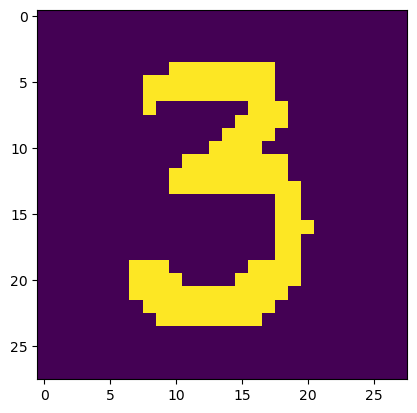

In [15]:
plt.imshow(X.to_numpy()[50].reshape(28, 28));
print(f"Число на картинке -> {y[50]}")

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_test, y_train, y_test = list(map(lambda x: x.to_numpy(), (X_train, X_test, y_train, y_test)))

In [17]:
y_train_ = np.zeros((len(y_train), 10))
for i in range(len(y_train)):
    y_train_[i, y_train[i]] = 1
y_test_ = np.zeros((len(y_test), 10))
for i in range(len(y_test)):
    y_test_[i, y_test[i]] = 1

In [18]:
y_test_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
nn = NeuralNetwork(inputs=784, hidden_layers=[50, 50], outputs=10, lr=0.5, initial_t=1, power_t=0.05)

In [32]:
nn.train(X_train, y_train_, epochs=5)

In [33]:
(np.argmax(nn.predict(X_test), axis=1) == y_test).mean() #доля верных предсказаний

0.9312142857142857